# Card Credit Card Fraud Detection using Neural Network
### By: Dhruv Jayant Verma#

Description
This is a classification problem where I design a neural network to predict wheather a transaction is fraud or not.

### Library pakages required:

In [37]:
# pip install pandas, numpy, matplotlib, seaborn, scikit-learn, imblearn, torch

### Importing Libraries 

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             confusion_matrix,
                             precision_recall_curve,
                             roc_curve,
                             auc)
from imblearn.over_sampling import SMOTE

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# To set the number of cores used by SMOTE
import os
import time
os.environ['LOKY_MAX_CPU_COUNT'] = str(8)

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Loading dataset
credit_data = pd.read_csv('creditcard.csv')

### Exploratory Data Analysis

Dataset shape: (283726, 31)

Number of duplicate rows: 0

Dataset shape after removing duplicates: (283726, 31)

Class distribution:
Class
0    283253
1       473
Name: count, dtype: int64


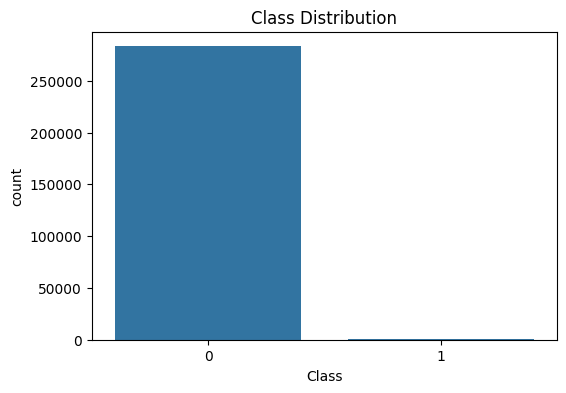

In [5]:
# Check the shape of the dataset
print(f"Dataset shape: {credit_data.shape}")

# Check for duplicate values
duplicate_rows = credit_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

# Remove duplicate rows
credit_data = credit_data.drop_duplicates()
print(f"\nDataset shape after removing duplicates: {credit_data.shape}")

# Check class distribution
class_counts = credit_data['Class'].value_counts()
print("\nClass distribution:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=credit_data)
plt.title("Class Distribution")
plt.show()

### Feature Engineering on 'Time' column

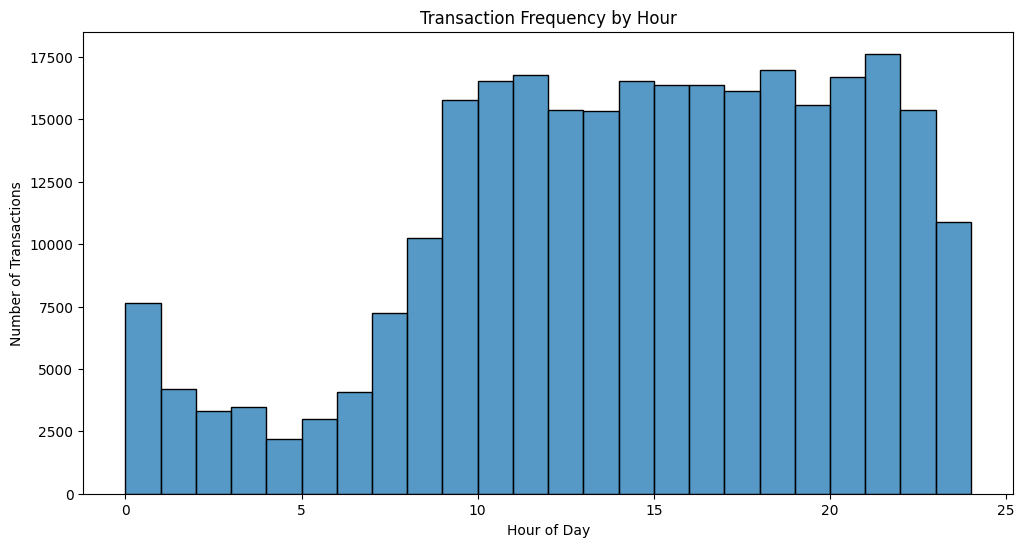

In [6]:
# Convert 'Time' from seconds to hours
credit_data['Hour'] = (credit_data['Time'] / 3600) % 24

# Drop the original 'Time' column
credit_data = credit_data.drop(['Time'], axis=1)

# Visualize transaction frequency by hour
plt.figure(figsize=(12,6))
sns.histplot(credit_data['Hour'], bins=24, kde=False)
plt.title("Transaction Frequency by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.show()

### Preparing Features and Target Variable

In [8]:
# Split the data into features (X) and target (y)
X = credit_data.drop(['Class'], axis=1)
y = credit_data['Class']

# Split data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

# Check the shape of the splits
print(f"X_train shape: {X_train.shape}")
print(f"\nX_test shape: {X_test.shape}")

X_train shape: (226980, 30)

X_test shape: (56746, 30)


### Feature Scaling after splitting data to prevent Data Leakage

In [9]:
# List of numerical features to scale
num_features = ['Amount', 'Hour']  # Include 'Hour' if necessary

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

# Note: It's important to fit the scaler only on the training data

### Handling `Class` (Target) imbalance using SMOTE on only the Training Data

Class distribution after applying SMOTE:
Class
0    226602
1    226602
Name: count, dtype: int64 



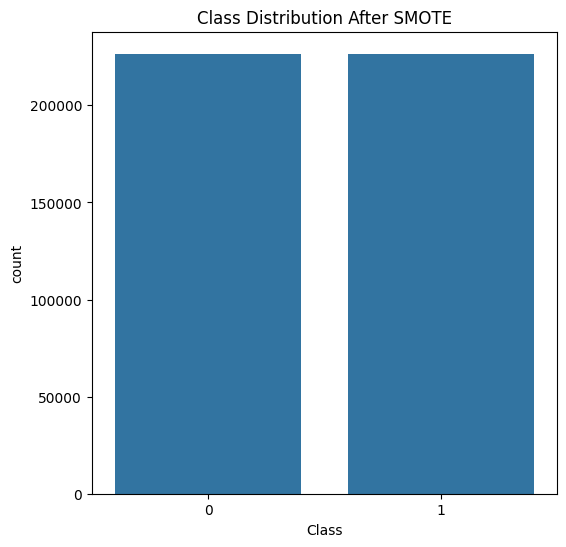

In [15]:
# Initialize SMOTE
smote = SMOTE(random_state=RANDOM_SEED)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after applying SMOTE:")
print(pd.Series(y_train_resampled).value_counts(),'\n')

# Visualize the new class distribution
plt.figure(figsize=(6,6))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

In [16]:
print(pd.Series(y_train_resampled).value_counts())

Class
0    226602
1    226602
Name: count, dtype: int64


### Converting Data to PyTorch Tensors & creating a DataLoader

In [17]:
# Convert to numpy arrays
X_train_np = X_train_resampled.values
y_train_np = y_train_resampled.values
X_test_np = X_test.values
y_test_np = y_test.values

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# No need for DataLoader for test data unless using mini-batches

### Defining Neural Network Architecture

In [18]:
# Define the neural network model
class FraudDetectionModel(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 2)  # Output layer for binary classification
        )
    
    def forward(self, x):
        return self.model(x)

In [19]:
# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = FraudDetectionModel(input_dim)

# Move the model to the GPU if available
if model.to(device):
    print("\n****Model successfully moved to the GPU****\n")
else:
    print("\n****Failed to move the model to GPU****\n")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


****Model successfully moved to the GPU****



#### Training the Model

In [20]:
num_epochs = 50
print(f'No of Epochs: {num_epochs}\n')
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Print the epoch and loss after every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

No of Epochs: 50

Epoch [10/50], Loss: 0.0376
Epoch [20/50], Loss: 0.0324
Epoch [30/50], Loss: 0.0302
Epoch [40/50], Loss: 0.0283
Epoch [50/50], Loss: 0.0275


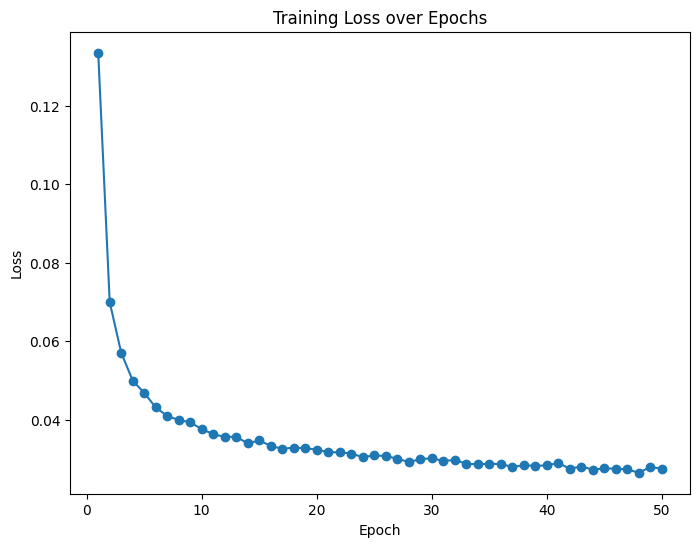

In [21]:
# Plot the training loss over epochs
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

### Evaluating Model on Test Data

In [22]:
# Evaluate the model on the test data

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    # Move test data to GPU if available
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    # Forward pass
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    
    # Get probabilities (for ROC and PR curves)
    probabilities = torch.softmax(outputs, dim=1)[:,1]
    
    # Move data back to CPU for evaluation metrics
    y_test_np = y_test_tensor.cpu().numpy()
    predicted_np = predicted.cpu().numpy()
    probabilities_np = probabilities.cpu().numpy()

### Classification Report

In [23]:
print(classification_report(y_test_np, predicted_np))

# Compute evaluation metrics
accuracy = accuracy_score(y_test_np, predicted_np)
precision = precision_score(y_test_np, predicted_np)
recall = recall_score(y_test_np, predicted_np)
f1 = f1_score(y_test_np, predicted_np)
roc_auc = roc_auc_score(y_test_np, probabilities_np)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.52      0.81      0.64        95

    accuracy                           1.00     56746
   macro avg       0.76      0.90      0.82     56746
weighted avg       1.00      1.00      1.00     56746

Accuracy: 0.9984
Precision: 0.5238
Recall (Sensitivity): 0.8105
F1 Score: 0.6364
ROC AUC Score: 0.9573


### Confusion Matrix

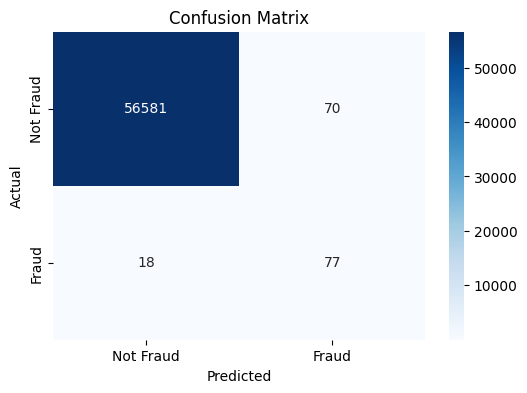

In [24]:
cm = confusion_matrix(y_test_np, predicted_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### ROC Area Curve 

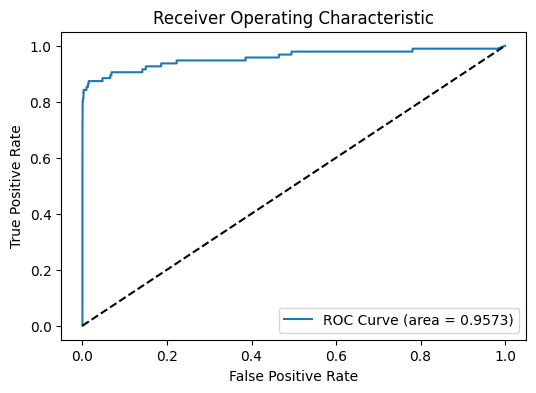

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_np, probabilities_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Precision-Recall Curve

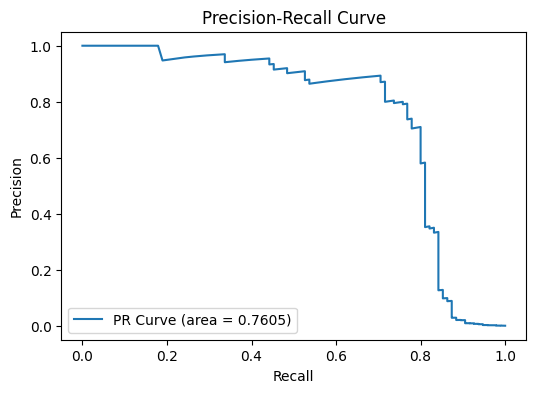

In [26]:
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_np, probabilities_np)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals, label='PR Curve (area = %0.4f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### Hyperparameter Tuning

In [30]:
# Define a function for training and evaluation to facilitate hyperparameter tuning
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move inputs and labels to the GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print epoch progress
        if (epoch + 1) % 2 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return model

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        # Move data to GPU if available
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)

        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:,1]

        y_test_np = y_test_tensor.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        probabilities_np = probabilities.cpu().numpy()

        f1 = f1_score(y_test_np, predicted_np)
    return f1

# Hyperparameter Grid
learning_rates = [0.001]
dropouts = [0.3, 0.5]
batch_sizes = [128]

best_f1 = 0.0
best_params = {}

for lr in learning_rates:
    for dropout in dropouts:
        for batch_size in batch_sizes:
            print(f"Testing with Learning Rate: {lr}, Dropout: {dropout}, Batch Size: {batch_size}")
            # Update model architecture with new dropout rate
            class FraudDetectionModel(nn.Module):
                def __init__(self, input_dim):
                    super(FraudDetectionModel, self).__init__()
                    self.model = nn.Sequential(
                        nn.Linear(input_dim, 64),
                        nn.BatchNorm1d(64),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(64, 32),
                        nn.BatchNorm1d(32),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(32, 16),
                        nn.BatchNorm1d(16),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(16, 2)
                    )

                def forward(self, x):
                    return self.model(x)

            # Initialize model, loss, optimizer
            model = FraudDetectionModel(input_dim).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            # Create DataLoader with new batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Train the model
            model = train_model(model, criterion, optimizer, train_loader, num_epochs=10)

            # Evaluate the model
            f1 = evaluate_model(model, X_test_tensor, y_test_tensor)

            print(f"LR: {lr}, Dropout: {dropout}, Batch Size: {batch_size}, F1 Score: {f1:.4f}\n")

            # Update best model if current one is better
            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'learning_rate': lr,
                    'dropout': dropout,
                    'batch_size': batch_size
                }
                best_model = model

print("Best Hyperparameters:")
print(best_params)
print(f"Best F1 Score: {best_f1:.4f}")

Testing with Learning Rate: 0.001, Dropout: 0.3, Batch Size: 128
Epoch [2/10], Loss: 0.0366, Time Taken: 0.00 sec
Epoch [4/10], Loss: 0.0248, Time Taken: 0.00 sec
Epoch [6/10], Loss: 0.0203, Time Taken: 0.00 sec
Epoch [8/10], Loss: 0.0185, Time Taken: 0.00 sec
Epoch [10/10], Loss: 0.0161, Time Taken: 0.00 sec
LR: 0.001, Dropout: 0.3, Batch Size: 128, F1 Score: 0.4873

Testing with Learning Rate: 0.001, Dropout: 0.5, Batch Size: 128
Epoch [2/10], Loss: 0.0732, Time Taken: 0.00 sec
Epoch [4/10], Loss: 0.0524, Time Taken: 0.00 sec
Epoch [6/10], Loss: 0.0456, Time Taken: 0.00 sec
Epoch [8/10], Loss: 0.0412, Time Taken: 0.00 sec
Epoch [10/10], Loss: 0.0381, Time Taken: 0.00 sec
LR: 0.001, Dropout: 0.5, Batch Size: 128, F1 Score: 0.4762

Best Hyperparameters:
{'learning_rate': 0.001, 'dropout': 0.3, 'batch_size': 128}
Best F1 Score: 0.4873


### Evaluating the best Model based on Hyperparameter Tuning

In [31]:
model = best_model
model.eval()

with torch.no_grad():
    # Ensure test data is on the correct device
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    probabilities = torch.softmax(outputs, dim=1)[:,1]
    
    y_test_np = y_test_tensor.cpu().numpy()
    predicted_np = predicted.cpu().numpy()
    probabilities_np = probabilities.cpu().numpy()

# Classification report
print(classification_report(y_test_np, predicted_np))

# Compute evaluation metrics
accuracy = accuracy_score(y_test_np, predicted_np)
precision = precision_score(y_test_np, predicted_np)
recall = recall_score(y_test_np, predicted_np)
f1 = f1_score(y_test_np, predicted_np)
roc_auc = roc_auc_score(y_test_np, probabilities_np)

# Print evaluation metrics
print(f"Accuracy: {accuracy * 100:.3f}%")
print(f"Precision: {precision * 100:.3f}%")
print(f"Recall (Sensitivity): {recall * 100:.3f}%")
print(f"F1 Score: {f1 * 100:.3f}%")
print(f"ROC AUC Score: {roc_auc * 100:.3f}%")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.35      0.81      0.49        95

    accuracy                           1.00     56746
   macro avg       0.67      0.90      0.74     56746
weighted avg       1.00      1.00      1.00     56746

Accuracy: 99.715%
Precision: 34.842%
Recall (Sensitivity): 81.053%
F1 Score: 48.734%
ROC AUC Score: 95.369%
